# ==============================================================
# Medical Provider Analysis:

In [18]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
import json
from pprint import pprint
import time
from api_keys import yelp_api
from api_keys import yelp_clientID
import csv
import matplotlib.pylab as plb
from scipy import stats
import statsmodels.api as sm

### Read in zipcode and life expectancy data, Create DataFrames 

In [8]:
#import life expectancyby tract ID data
life_expectancy_by_tract = pd.read_csv('CA_A.csv')

#import the track to zip code data
tract_to_zip = pd.read_excel('TRACT_ZIP_092019.xlsx')

#create dataframe for life expectancy by tract ID data
life_expectancy_by_tract_df = pd.DataFrame(life_expectancy_by_tract)

#pull out tract ID and life expectancy (e(0))
life_expectancy_by_tract_df = life_expectancy_by_tract_df[['Tract ID','e(0)']]

#rename life expectancy column
life_expectancy_by_tract_df = life_expectancy_by_tract_df.rename(columns={'e(0)':'Life Expectancy'})

#create dataframe with tract to zip
tract_to_zip_df = pd.DataFrame(tract_to_zip)

#pull out tract ID and zip code
tract_to_zip_df = tract_to_zip_df[['tract','zip']]

#rename tract ID column
tract_to_zip_df = tract_to_zip_df.rename(columns={'tract':'Tract ID'})

#Merge the 2 dataframes
test_df = pd.merge(life_expectancy_by_tract_df,tract_to_zip_df)

#group by zip code and take mean of the life expectancy per zip code
mean_df = test_df.groupby('zip').mean()

#drop track ID
mean_df = mean_df.drop(columns=['Tract ID'])

zip_string = [str(zip) for zip in mean_df.index.values]

life_df = mean_df.copy()

life_df.head(10)

,Life Expectancy
zip,
90001,77.733333
90002,76.537500
90003,76.560606
90004,81.928571
90005,80.481818
90006,78.624138
90007,78.050000
90008,78.154545
90010,81.207692


## Yelp Search
### First 1000 zip codes

In [6]:
#create empty list to store medical providers
all_hosp = []
all_zip = []
hosp_per_zip = []
hosp_names_per_zip = []
hosp_zip_list=[]
life_exp_list=[]

#loop through the list of zip codes
for zcode in zip_string[0:1000]:
    print('***********************************************')
    print('-----------------------------------------------')
    print(f'Hospitals in {zcode}')
    print('-----------------------------------------------')
    
    #api url
    url = 'https://api.yelp.com/v3/businesses/search'
    offset=0
    params = {
        'Authorization': yelp_api,
        'term':'hospital',
        'location':zcode,
        'categories':'hospitals, All',
        'limit':50,
        'offset':offset,
        'sort_by':'distance'
            }
    header = {'Authorization': f'Bearer {yelp_api}'}
    #get requesst from API
    response = requests.get(url,headers=header,params=params).json()
    
    #list comprehension to pick out medical providers from reponse JSON
    #wrap in try and except in the case some of the data is not complete
    try:
        hosp_names = [response_name['name'] for response_name in response['businesses']]
        
    except: 
        next
        
        
    #print names of medical providers, #of medical providers per request and total
    print(hosp_names)
    print(f'Number of Hospitals in request: {len(hosp_names)}')
    total_hosp = len(hosp_names)
    print(f'Number of Total Hospitals: {total_hosp}')
    hosp_per_zip = hosp_names
    while len(hosp_names) == 50:
            offset = offset+50
            params = {
            'Authorization': yelp_api,
            'term':'hospital',
            'location':zcode,
            'categories':'hospitals, All',
            'limit':50,
            'offset':offset,
            'sort_by':'distance'
                }
            header = {'Authorization': f'Bearer {yelp_api}'}
          #list comprehension to pick out medical providers from reponse JSON
          #wrap in try and except in the case some of the data is not complete
            response = requests.get(url,headers=header,params=params).json()
          
            try:
                hosp_names = [response_name['name'] for response_name in response['businesses']]
                
            except:
                next
            print(hosp_names)
            print(f'Number of Hospitals: {len(hosp_names)}')
            total_hosp = total_hosp + len(hosp_names)
            print(f'Number of Total Hospitals: {total_hosp}')
            print('***********************************************')
            hosp_per_zip.extend(hosp_names)
    #add the number of medical providers, zip code, and the names of the medical providers the their appropriate list
    all_hosp.append(total_hosp)
    all_zip.append(zcode)
    hosp_names_per_zip.append(hosp_per_zip)
   
    #find the life expectancy that corresponds to the zip code being searched in the life_df then add to list
    life_expectancy = life_df[life_df.index==int(zcode)]['Life Expectancy'].values
    life_exp_list.append(life_expectancy)
    
    #create tuple with necessary data and add to list
    hosp_tuple = (zcode,life_expectancy,total_hosp, hosp_per_zip)
    hosp_zip_list.append(hosp_tuple)
    
    #wrtie to csv file
    with open('hosp_1.csv','a') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(hosp_tuple)

***********************************************
-----------------------------------------------
Hospitals in 90001
-----------------------------------------------
['Little Company of Mary San Pedro', 'White Memorial Specialty Medical Groups', 'Community Hospital of Huntington Park', 'St Francis Medical Clinic At Huntington Park', 'Senior Health Care of Mission Hospital', 'Stacy Medical Center', 'Kedren Health']
Number of Hospitals in request: 7
Number of Total Hospitals: 7
***********************************************
-----------------------------------------------
Hospitals in 90002
-----------------------------------------------
['Little Company of Mary San Pedro', 'White Memorial Specialty Medical Groups', 'Martin Luther King Jr Community Hospital', 'Senior Health Care of Mission Hospital', 'Community Hospital of Huntington Park', 'St Francis Medical Clinic At Huntington Park', 'Kedren Health']
Number of Hospitals in request: 7
Number of Total Hospitals: 7
************************

In [9]:
# Read in CSV file with API request data
hosp_1_read = pd.read_csv('hosp_1.csv',header=None)

# Create DataFrame with correct column names
hosp_1_read_df = pd.DataFrame(hosp_1_read)
hosp_1_read_df = hosp_1_read_df.rename(columns={
    0:'Zip Code',
    1:'Life Expectancy',
    2:'Number of Medical Providers',
    3:'Names of Medical Providers'
})

# Find the unique provider names, count the unique provider names, append to DataFrame complete_data for final analysis
unique_hosp_list = []
num_unique_hosp_list = []
complete_data = hosp_1_read_df.copy()

complete_data.head()

,Zip Code,Life Expectancy,Number of Medical Providers,Names of Medical Providers
0,90001,[77.73333333],7,[]
1,90002,[76.5375],7,[]
2,90003,[76.56060606],22,[]
3,90004,[81.92857143],57,[]
4,90005,[80.48181818],55,[]


In [14]:
#seperated the zip codes becasue of API request limit
all_hosp_2 = []
all_zip_2 = []
hosp_per_zip = []
hosp_names_per_zip_2 = []
hosp_zip_list_2=[]
life_exp_list_2=[]
#loop through the remaining zip codes
for zcode in zip_string[1000:]:
    print('***********************************************')
    print('-----------------------------------------------')
    print(f'Hospitals in {zcode}')
    print('-----------------------------------------------')
    
    #api url
    url = 'https://api.yelp.com/v3/businesses/search'
    #insert params
    offset=0
    params = {
        'Authorization': yelp_api,
        'term':'hospital',
        'location':zcode,
        'categories':'hospitals, All',
        'limit':50,
        'offset':offset,
        'sort_by':'distance'
            }
    header = {'Authorization': f'Bearer {yelp_api}'}
    #get requesst from API
    response = requests.get(url,headers=header,params=params).json()
    
    #list comprehension to pick out medical providers from reponse JSON
    #wrap in try and except in the case some of the data is not complete
    try:
        hosp_names = [response_name['name'] for response_name in response['businesses']]
        
    except: 
        next
    print(hosp_names)
    print(f'Number of Hospitals in request: {len(hosp_names)}')
    total_hosp = len(hosp_names)
    print(f'Number of Total Hospitals: {total_hosp}')
    hosp_per_zip = hosp_names
    while len(hosp_names) == 50:
            offset = offset+50
            params = {
            'Authorization': yelp_api,
            'term':'hospital',
            'location':zcode,
            'categories':'hospitals, All',
            'limit':50,
            'offset':offset,
            'sort_by':'distance'
                }
            header = {'Authorization': f'Bearer {yelp_api}'}
         
            response = requests.get(url,headers=header,params=params).json()
            #list comprehension to pick out medical providers from reponse JSON
            #wrap in try and except in the case some of the data is not complete
            try:
                hosp_names = [response_name['name'] for response_name in response['businesses']]
                
            except:
                next
            
            print(hosp_names)
            print(f'Number of Hospitals: {len(hosp_names)}')
            total_hosp = total_hosp + len(hosp_names)
            print(f'Number of Total Hospitals: {total_hosp}')
            print('***********************************************')
            hosp_per_zip.extend(hosp_names)
            if total_hosp == 1000:
                break
    
    #add the number of medical providers, zip code, and the names of the medical providers the their appropriate list
    all_hosp_2.append(total_hosp)
    all_zip_2.append(zcode)
    hosp_names_per_zip_2.append(hosp_per_zip)
   
    #find the life expectancy that corresponds to the zip code being searched in the life_df then add to list
    life_expectancy = life_df[life_df.index==int(zcode)]['Life Expectancy'].values
    life_exp_list_2.append(life_expectancy)
    
    #create tuple with necessary data and add to list
    hosp_tuple_2 = (zcode,life_expectancy,total_hosp, hosp_per_zip)
    hosp_zip_list_2.append(hosp_tuple)
    
    #write csv file
    with open('hosp_2.csv','a') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(hosp_tuple_2)

***********************************************
-----------------------------------------------
Hospitals in 93062
-----------------------------------------------
['Aspen Outpatient Imaging', 'Adventist Health Simi Valley', 'Adventist Health Simi Valley', 'Saxon Surgical Center', 'Los Robles Hospital', 'Livingston Memorial Visiting Nurse Association', 'Thousand Oaks Surgical Hospital', 'WESTLAKE SURGICAL CENTER', 'West Hills Hospital & Medical Center', "Women's Diagnostic Center At West Hills Hospital & Medical Cente", 'Mary Health of the Sick', 'Community Memorial Hospital', 'Fillmore Medical Center', 'Kaiser Permanente Woodland Hills Medical Center']
Number of Hospitals in request: 14
Number of Total Hospitals: 14
***********************************************
-----------------------------------------------
Hospitals in 93063
-----------------------------------------------
['Adventist Health Simi Valley', 'Adventist Health Simi Valley', 'Aspen Outpatient Imaging', "Women's Diagnosti

In [23]:
# Second SET (ZIPS 1000-2337)

# Read in CSV file with API request data for second set
hosp_2_read = pd.read_csv('hosp_2.csv',header=None)

# Create DataFrame with correct column names
hosp_read_df_2 = pd.DataFrame(hosp_2_read)
hosp_read_df_2 = hosp_read_df_2.rename(columns={
    0:'Zip Code',
    1:'Life Expectancy',
    2:'Number of Medical Providers',
    3:'Names of Medical Providers'
})

# Find the unique Name of Medical Providers, count the unique Name of Medical Providers, append to DataFrame complete_data for final analysis
unique_hosp_list_2 = []
num_unique_hosp_list_2 = []
complete_data_2 = hosp_read_df_2.copy()
for i in range(0,len(complete_data_2)):
    list_test_2 = complete_data_2['Names of Medical Providers'][i]
    split_list_2 =list_test_2.split(',')
    split_array_2 = np.array(split_list_2)
    unique_array_2 = np.unique(split_array_2)
    num_unique_2 = len(unique_array_2)
    unique_hosp_list_2.append(unique_array_2)
    num_unique_hosp_list_2.append(num_unique_2)
complete_data_2['Number of Medical Providers'] = num_unique_hosp_list_2

complete_data_2.head()

,Zip Code,Life Expectancy,Number of Medical Providers,Names of Medical Providers
0,93062,[76.3],13,"['Aspen Outpatient Imaging', 'Adventist Health..."
1,93063,[81.01428571],22,"['Adventist Health Simi Valley', 'Adventist He..."
2,93064,[82.8],4,"['Aspen Outpatient Imaging', 'Adventist Health..."
3,93065,[80.53333333],13,"['Aspen Outpatient Imaging', 'Adventist Health..."
4,93066,[80.66666667],20,['Humphrey Giacopuzzi & Associates Equine Hosp...


## Merge 2 DataFrames

In [25]:
# merge the 2 dataframes: complete_data and complete_data_2:
all_data_df = pd.concat([complete_data,complete_data_2],axis=0,sort=True)
all_data_df = all_data_df.reset_index()
all_data_df = all_data_df.drop(columns={'index'})

# Create copy of all_data_df (the merged DataFrames)
graph_df_all = all_data_df.copy()

# Convert Life Expectancy from type list to type float
graph_df_all['Life Expectancy'] = graph_df_all['Life Expectancy'].str.strip('[]').astype(float)

#drop unecessary columns
graph_df_all = graph_df_all.drop(columns={'Names of Medical Providers'})
graph_df_all.head()

,Life Expectancy,Number of Medical Providers,Zip Code
0,77.733333,7,90001
1,76.537500,7,90002
2,76.560606,22,90003
3,81.928571,57,90004
4,80.481818,55,90005


## Analysis

In [21]:
# Correlation Coefficient:
r = np.corrcoef(graph_df_all['Number of Medical Providers'].values,graph_df_all['Life Expectancy'].values)
corr_coeff_all = r[1,0]
print(f'Correlation Coefficient: {corr_coeff_all}')

x_hosp_all = graph_df_all['Number of Medical Providers'].values
y_life_all = graph_df_all['Life Expectancy'].values

## Cross Checking with the internal scipy function
t2_all, p2_all = stats.ttest_ind(x_hosp_all,y_life_all)
print("t-statistic = " + str(t2_all))
print("p-value = " + str(p2_all))

# Print the OLS Regression Results:
results = sm.OLS(y_life_all,sm.add_constant(x_hosp_all)).fit()
print(results.summary())

Correlation Coefficient: 0.07187383160835255
t-statistic = -75.09787375834642
p-value = 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.33
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           0.000453
Time:                        10:30:54   Log-Likelihood:                -6078.9
No. Observations:                2377   AIC:                         1.216e+04
Df Residuals:                    2375   BIC:                         1.217e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

## Graph

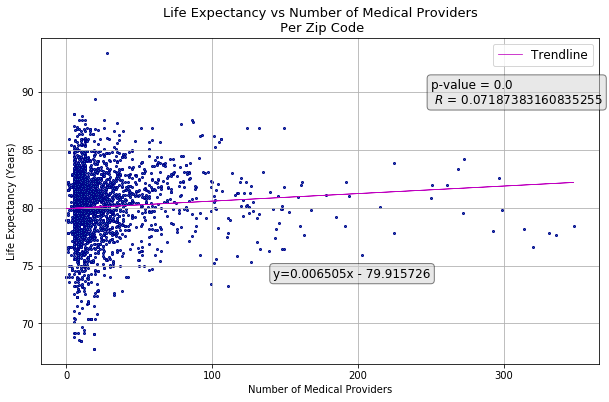

In [22]:
# Set figure size
plt.figure(figsize=(10,6))

# Scatter plot of life expectancy verses number of medical providerss, set marker size to 4
plt.scatter(graph_df_all['Number of Medical Providers'].values,graph_df_all['Life Expectancy'].values,4,edgecolor='darkblue')

# Label axes, add title
plt.xlabel('Number of Medical Providers')
plt.ylabel('Life Expectancy (Years)')
plt.title('Life Expectancy vs Number of Medical Providers\n Per Zip Code',size=13)
plt.yticks(np.arange(0,100,5))
plt.xticks(np.arange(0,1000,100))
plt.grid()


# Calculate and add trendline
z = np.polyfit(graph_df_all['Number of Medical Providers'].values,graph_df_all['Life Expectancy'].values, 1)

p = np.poly1d(z)

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

# Plot the trendline equation to graph
plt.text(250,74,"y=%.6fx - %.6f"%(z[0],abs(z[1])), ha='right',size=12, bbox=props)

# plot the p-value and correlation coefficient to graph
plt.text(250,89,f"p-value = {str(p2_all)}\n $R$ = {corr_coeff_all}",size=12,bbox=props)

# Plot trendline
plb.plot(graph_df_all['Number of Medical Providers'].values, p(graph_df_all['Number of Medical Providers'].values), 'm-',linewidth=.75)

# Add legend
plt.legend(['Trendline'],fontsize=12)

# Save the figure
plt.savefig('hosp_scatter.png',bbox_inches="tight")

Null Hypothesis: Life expectancy does not increase for zip codes that have more medical providers

Alternative Hypothesis: Life expectancy increases for zip codes that have more medical providers

Testing at alpha = 0.1

Since the p-value is 0.00, which is less than alpha=0.1, we reject the null hypothesis. The results are statistically significant at the alpha = 0.1 level

As the graph shows, the linear trendline has a positive slope (r = .07). Thus there is a weak positive correlation between life expectancy and number of medical providers per zip code.